# Automatically generating object masks with SAM

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)

This notebook shows how to segment objects from an image using the Segment Anything Model (SAM) with a few lines of code.

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

The notebook is adapted from [segment-anything/notebooks/automatic_mask_generator_example.ipynb](https://github.com/opengeos/segment-anything/blob/pypi/notebooks/automatic_mask_generator_example.ipynb), but I have made it much easier to save the segmentation results and visualize them.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
!pip install segment-geospatial leafmap # Install the required packages.


In [2]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map

In [3]:
m = leafmap.Map(center=[25.56, 91.88], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[25.56, 91.88], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [4]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [91.2659, 25.34, 91.88, 25.57]

## Download a sample image

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Streaming output truncated to the last 5000 lines.
Downloaded image 16152/21150
Downloaded image 16153/21150
Downloaded image 16154/21150
Downloaded image 16155/21150
Downloaded image 16156/21150
Downloaded image 16157/21150
Downloaded image 16158/21150
Downloaded image 16159/21150
Downloaded image 16160/21150
Downloaded image 16161/21150
Downloaded image 16162/21150
Downloaded image 16163/21150
Downloaded image 16164/21150
Downloaded image 16165/21150
Downloaded image 16166/21150
Downloaded image 16167/21150
Downloaded image 16168/21150
Downloaded image 16169/21150
Downloaded image 16170/21150
Downloaded image 16171/21150
Downloaded image 16172/21150
Downloaded image 16173/21150
Downloaded image 16174/21150
Downloaded image 16175/21150
Downloaded image 16176/21150
Downloaded image 16177/21150
Downloaded image 16178/21150
Downloaded image 16179/21150
Downloaded image 16180/21150
Downloaded image 16181/21150
Downloaded image 16182/21150
Downloaded image 16183/21150
Downloaded image 1618

You can also use your own image. Uncomment and run the following cell to use your own image.

In [ ]:
# image = '/path/to/your/own/image.tif'

Display the downloaded image on the map.

In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [20]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object.

In [9]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

In [ ]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

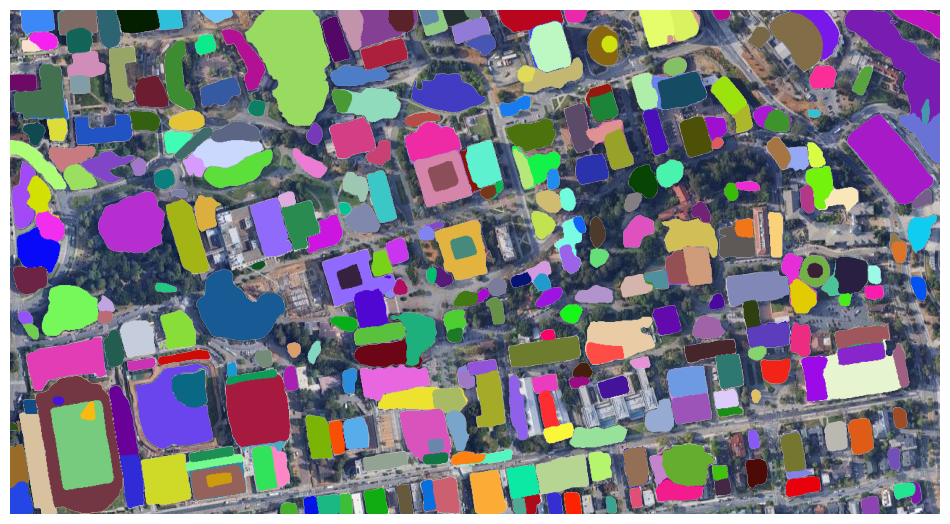

In [10]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

Compare images with a slider.


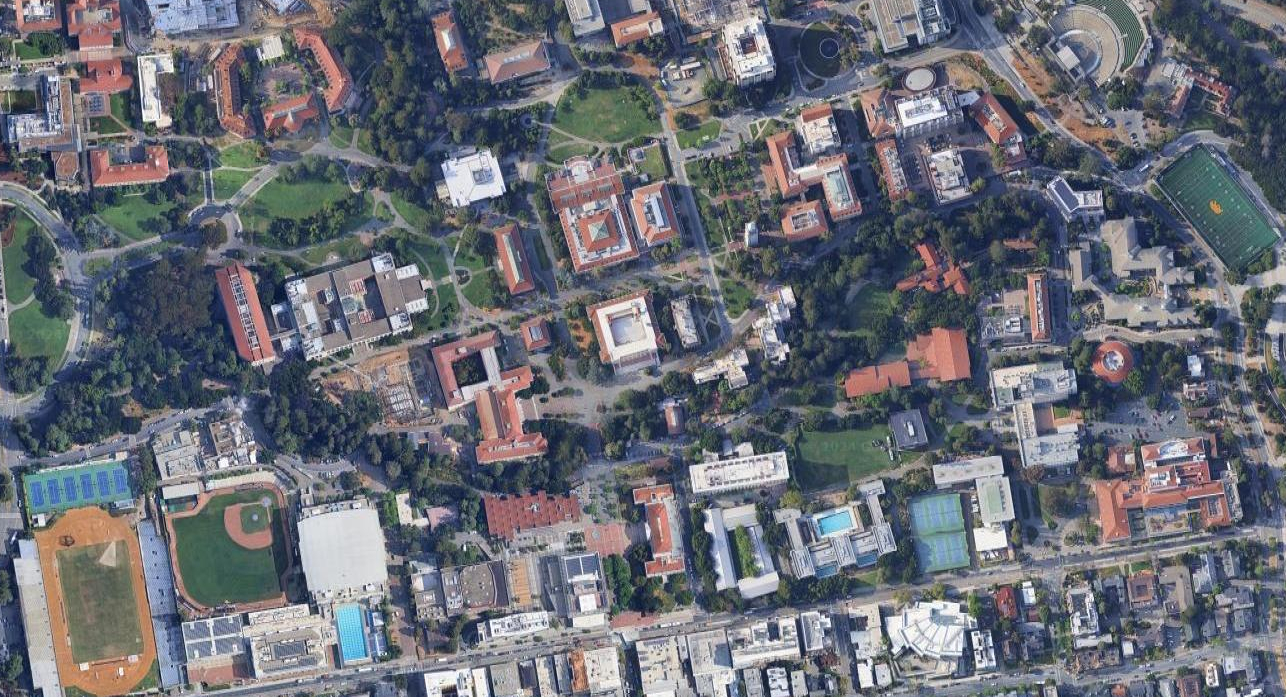
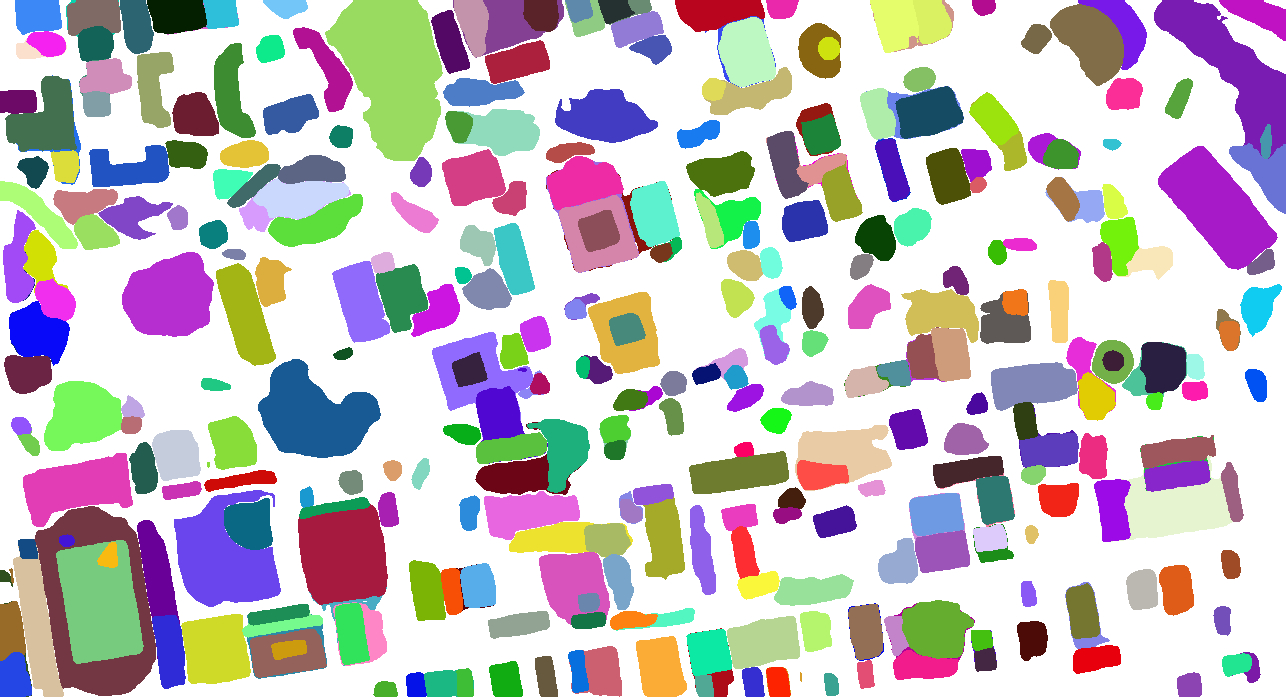

In [11]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Add image to the map.

In [12]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=3239933.0, center=[37.87115, -122.259], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [14]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate(image, output="masks2.tif", foreground=True)

In [ ]:
sam.show_masks(cmap="binary_r")

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

Compare images with a slider.

In [ ]:
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)

Overlay the annotations on the image and use the slider to change the opacity interactively.

In [ ]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

![](https://i.imgur.com/I1IhDgz.gif)